In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

In [2]:
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
MONTHS = ["oct23", "nov23", "dec23"]  # Add more months as you expand


In [3]:
monthly_token_data = {}

for month in MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    month_prices = {}
    month_volumes = {}

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns or 'volume' not in df.columns:
                continue

            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['days_since_launch'] = df.index
            month_prices[token] = df[['days_since_launch', 'close']].set_index('days_since_launch').rename(columns={'close': token})
            month_volumes[token] = df[['days_since_launch', 'volume']].set_index('days_since_launch').rename(columns={'volume': token})
        except Exception as e:
            print(f"⚠️ Error in {token}: {e}")

    if month_prices and month_volumes:
        aligned_prices = pd.concat(month_prices.values(), axis=1, join='inner')
        aligned_volumes = pd.concat(month_volumes.values(), axis=1, join='inner')

        monthly_token_data[month] = {
            "prices": aligned_prices,
            "volumes": aligned_volumes
        }

        print(f"✅ Loaded {month}: {aligned_prices.shape[1]} tokens, {aligned_prices.shape[0]} days")
    else:
        print(f"❌ Skipped {month}: No valid token data found")


✅ Loaded oct23: 5 tokens, 369 days
✅ Loaded nov23: 5 tokens, 374 days
✅ Loaded dec23: 5 tokens, 275 days


📈 oct23: Final portfolio value = 222931.36
📈 nov23: Final portfolio value = 1286276.53
📈 dec23: Final portfolio value = 5998088.57


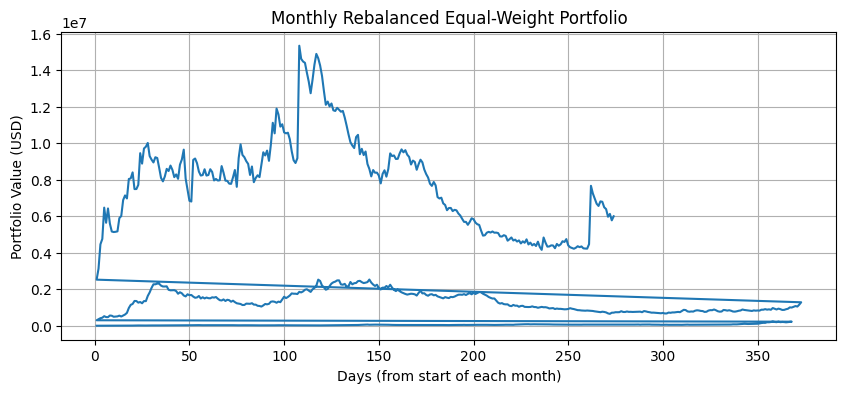

In [4]:
import numpy as np
import matplotlib.pyplot as plt

initial_capital = 1000  # Starting with $1000
portfolio_values = []  # Store cumulative portfolio values for each month
current_value = initial_capital

for month in MONTHS:
    data = monthly_token_data.get(month)
    if data is None:
        print(f"⏭️ Skipping {month} (no data)")
        continue

    prices = data["prices"]
    returns = prices.pct_change().dropna()

    # Equal weights
    n_tokens = returns.shape[1]
    weights = np.repeat(1 / n_tokens, n_tokens)

    # Daily portfolio return = dot product of weights and daily token returns
    portfolio_daily_return = returns @ weights

    # Cumulative value (starting from current_value)
    portfolio_cumulative = (1 + portfolio_daily_return).cumprod() * current_value

    # Store and update value
    portfolio_values.append(portfolio_cumulative)
    current_value = portfolio_cumulative.iloc[-1]

    print(f"📈 {month}: Final portfolio value = {current_value:.2f}")

# Combine all months into one series
total_portfolio = pd.concat(portfolio_values)
total_portfolio.plot(title="Monthly Rebalanced Equal-Weight Portfolio", figsize=(10, 4))
plt.ylabel("Portfolio Value (USD)")
plt.xlabel("Days (from start of each month)")
plt.grid(True)
plt.show()


In [5]:
for month in MONTHS:
    data = monthly_token_data.get(month)
    if data:
        tokens = data["prices"].columns.tolist()
        print(f"📅 {month}: {len(tokens)} tokens → {tokens}")


📅 oct23: 5 tokens → ['JOE', 'KIZUNA', 'HAY', 'TITANX', 'BIGTIME']
📅 nov23: 5 tokens → ['MUBI', 'GROK', 'FLIP', 'MEME', 'TURT']
📅 dec23: 5 tokens → ['WBRGE', 'DOVA', 'PEAS', 'POINTS', '1CAT']


### Fully Rebalancing Portfolio

In [6]:
prev_tokens = None

for month in MONTHS:
    data = monthly_token_data.get(month)
    if not data:
        continue

    tokens = set(data["prices"].columns)
    print(f"\n📅 {month}")

    if prev_tokens is not None:
        added = tokens - prev_tokens
        removed = prev_tokens - tokens

        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")
    else:
        print(f"🆕 Initial tokens: {sorted(tokens)}")

    prev_tokens = tokens



📅 oct23
🆕 Initial tokens: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 nov23
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 dec23
➕ Added: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
➖ Removed: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']


### Partial Rebalancing Portfolio

In [7]:
portfolio = set()

for i, month in enumerate(MONTHS):
    data = monthly_token_data.get(month)
    if not data:
        print(f"❌ No data for {month}")
        continue

    month_tokens = set(data["prices"].columns)

    if i == 0:
        # For the first month, initialize portfolio from top 5 tokens by volume this month
        volumes = data["volumes"][list(month_tokens)]
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)
        portfolio = set(avg_volumes.head(5).index)
        print(f"📅 {month} - Initial Portfolio: {sorted(portfolio)}")
    else:
        # For subsequent months, partial rebalancing

        # Combine current portfolio tokens + new tokens launched this month
        tokens_to_consider = portfolio.union(month_tokens)

        available_tokens = set(data["volumes"].columns)
        tokens_to_consider = tokens_to_consider.intersection(available_tokens)

        if not tokens_to_consider:
            print(f"❌ No valid tokens to consider for {month}")
            continue

        volumes = data["volumes"][list(tokens_to_consider)]
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)

        # Pick top 5 by volume to form new portfolio
        new_portfolio = set(avg_volumes.head(5).index)

        added = new_portfolio - portfolio
        removed = portfolio - new_portfolio

        print(f"\n📅 {month}")
        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")

        portfolio = new_portfolio


📅 oct23 - Initial Portfolio: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 nov23
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 dec23
➕ Added: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
➖ Removed: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']


In [11]:
portfolio = set()

for i, month in enumerate(MONTHS):
    data = monthly_token_data.get(month)
    if not data:
        print(f"❌ No data for {month}")
        continue

    month_tokens = set(data["prices"].columns)

    if i == 0:
        # First month: initialize portfolio with top 5 tokens by volume
        volumes = data["volumes"][list(month_tokens)]
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)
        portfolio = set(avg_volumes.head(5).index)
        print(f"📅 {month} - Initial Portfolio: {sorted(portfolio)}")
    else:
        # Partial rebalancing:
        # Combine previous portfolio + new tokens from this month
        tokens_to_consider = portfolio.union(month_tokens)

        # Filter only tokens that have volume data in this month
        available_tokens = set(data["volumes"].columns)
        tokens_to_consider = tokens_to_consider.intersection(available_tokens)

        if not tokens_to_consider:
            print(f"❌ No valid tokens to consider for {month}")
            continue

        volumes = data["volumes"][list(tokens_to_consider)]
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)

        # Pick top 5 tokens by volume to form new portfolio
        new_portfolio = set(avg_volumes.head(5).index)

        added = new_portfolio - portfolio
        removed = portfolio - new_portfolio

        print(f"\n📅 {month}")
        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")

        portfolio = new_portfolio


📅 oct23 - Initial Portfolio: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 nov23
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']


In [22]:
portfolio = set()  # Initialize portfolio before loop

for i, month in enumerate(MONTHS):
    data = monthly_token_data.get(month)
    if not data:
        print(f"❌ No data for {month}")
        continue

    month_tokens = set(data["prices"].columns)

    volumes = data["volumes"][list(month_tokens)].fillna(0)
    avg_volumes = volumes.mean(axis=0)
    avg_volumes = avg_volumes[avg_volumes > 0].sort_values(ascending=False)

    if i == 0:
        # First month: pick top 5 tokens by volume as initial portfolio
        portfolio = set(avg_volumes.head(5).index)
        print(f"📅 {month} - Initial Portfolio: {sorted(portfolio)}")
    else:
        tokens_to_consider = portfolio.union(month_tokens)
        available_tokens = set(data["volumes"].columns)
        tokens_to_consider = tokens_to_consider.intersection(available_tokens)

        if not tokens_to_consider:
            print(f"❌ No valid tokens to consider for {month}")
            continue

        volumes = data["volumes"][list(tokens_to_consider)].fillna(0)
        avg_volumes = volumes.mean(axis=0).sort_values(ascending=False)

        # Debug prints for old portfolio volumes available this month
        available_portfolio_tokens = [t for t in portfolio if t in avg_volumes.index]
        print(f"Old portfolio volumes (available tokens):\n{avg_volumes.loc[available_portfolio_tokens].sort_values(ascending=False)}")

        # Debug prints for new tokens volumes
        available_new_tokens = [t for t in month_tokens if t in avg_volumes.index]
        print(f"New month tokens volumes (available tokens):\n{avg_volumes.loc[available_new_tokens].sort_values(ascending=False)}")

        new_portfolio = set(avg_volumes.head(5).index)

        added = new_portfolio - portfolio
        removed = portfolio - new_portfolio

        print(f"\n📅 {month}")
        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")

        portfolio = new_portfolio


📅 oct23 - Initial Portfolio: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']
Old portfolio volumes (available tokens):
Series([], dtype: float64)
New month tokens volumes (available tokens):
TURT    1.056400e+44
MUBI    2.478843e+06
GROK    2.114450e+06
FLIP    8.168658e+05
MEME    1.340902e+05
dtype: float64

📅 nov23
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']


In [8]:
portfolio = set()

for i, month in enumerate(MONTHS):
    data = monthly_token_data.get(month)
    if not data:
        print(f"❌ No data for {month}")
        continue

    month_tokens = set(data["prices"].columns)

    volumes = data["volumes"].fillna(0)  # fill NaNs to avoid issues

    if i == 0:
        # Initial portfolio: top 5 tokens by average volume this month
        avg_volumes = volumes.mean(axis=0)
        avg_volumes = avg_volumes[avg_volumes > 0].sort_values(ascending=False)
        portfolio = set(avg_volumes.head(5).index)
        print(f"📅 {month} - Initial Portfolio: {sorted(portfolio)}")
    else:
        # Partial rebalance:
        # Combine old portfolio with new tokens this month
        tokens_to_consider = portfolio.union(month_tokens)

        # Only consider tokens that have volume data this month
        tokens_to_consider = tokens_to_consider.intersection(set(volumes.columns))

        if not tokens_to_consider:
            print(f"❌ No valid tokens to consider for {month}")
            continue

        avg_volumes = volumes[list(tokens_to_consider)].mean(axis=0)
        avg_volumes = avg_volumes[avg_volumes > 0].sort_values(ascending=False)

        # Pick top 5 tokens by volume from combined set
        new_portfolio = set(avg_volumes.head(5).index)

        added = new_portfolio - portfolio
        removed = portfolio - new_portfolio

        print(f"\n📅 {month} - Partial Rebalance")
        print(f"➕ Added: {sorted(added)}")
        print(f"➖ Removed: {sorted(removed)}")

        portfolio = new_portfolio

    print(f"Current Portfolio after {month}: {sorted(portfolio)}")


📅 oct23 - Initial Portfolio: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']
Current Portfolio after oct23: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']

📅 nov23 - Partial Rebalance
➕ Added: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
➖ Removed: ['BIGTIME', 'HAY', 'JOE', 'KIZUNA', 'TITANX']
Current Portfolio after nov23: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']

📅 dec23 - Partial Rebalance
➕ Added: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
➖ Removed: ['FLIP', 'GROK', 'MEME', 'MUBI', 'TURT']
Current Portfolio after dec23: ['1CAT', 'DOVA', 'PEAS', 'POINTS', 'WBRGE']
